# Exploratory Data Analysis of the OGBN-ARXIV Dataset

This notebook provides a simple EDA of the `ogbn-arxiv` dataset from the Open Graph Benchmark (OGB).

In [2]:
from ogb.nodeproppred import NodePropPredDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore", message=".*weights_only=False.*")

C:\Users\josep\miniconda3\envs\myenv\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Load Dataset

In [3]:
dataset = NodePropPredDataset(name="ogbn-arxiv", root="../../data/ogb")
graph, labels = dataset[0]
data = pd.DataFrame(data=graph['node_feat'])
data['label'] = labels.flatten()

## Summary Statistics and View Data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169343 entries, 0 to 169342
Columns: 129 entries, 0 to label
dtypes: float32(128), int64(1)
memory usage: 84.0 MB


In [5]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,-0.057943,-0.052530,-0.072603,-0.026555,0.130435,-0.241386,-0.449242,-0.018443,-0.087218,0.112320,...,-0.226118,-0.185603,0.053230,0.332873,0.104175,0.007408,0.173364,-0.172796,-0.140059,4
1,-0.124500,-0.070665,-0.325202,0.007779,-0.001559,0.074189,-0.191013,0.049689,0.026369,0.099364,...,0.052926,-0.258378,0.021567,0.281503,-0.173423,0.202082,0.068524,-0.372111,-0.301036,5
2,-0.080242,-0.023328,-0.183787,-0.180707,0.075765,-0.125818,-0.394573,-0.219078,-0.108931,0.056966,...,-0.070291,-0.177562,-0.214012,0.182186,-0.121589,-0.073642,0.109919,0.117589,-0.139883,28
3,-0.145044,0.054915,-0.126666,0.039971,-0.055909,-0.101278,-0.339202,-0.115801,-0.080058,-0.001633,...,0.042735,0.066338,-0.226921,0.188418,-0.017295,0.063449,0.017816,0.085364,-0.081804,8
4,-0.071154,0.070766,-0.281432,-0.161892,-0.165246,-0.029116,-0.338593,-0.138727,0.100015,0.132794,...,0.047475,-0.263795,0.026462,0.376349,-0.253772,0.084472,0.098033,-0.075347,-0.111687,27


## Feature stats

In [6]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
count,169343.000000,169343.000000,169343.000000,169343.000000,169343.000000,169343.000000,169343.000000,169343.000000,169343.000000,169343.000000,...,169343.000000,169343.000000,169343.000000,169343.000000,169343.000000,169343.000000,169343.000000,169343.000000,169343.000000,169343.000000
mean,-0.095499,0.018615,-0.200257,-0.050083,0.049301,-0.085223,-0.369258,-0.111832,0.083998,0.045889,...,-0.015715,-0.186888,-0.080385,0.315474,-0.091896,0.133277,0.113858,-0.062727,-0.128833,20.678942
std,0.104758,0.107904,0.114009,0.117657,0.106438,0.107370,0.114723,0.130831,0.143300,0.115817,...,0.107518,0.119634,0.101783,0.110269,0.139333,0.116601,0.106253,0.114659,0.098771,9.924934
min,-0.753942,-0.711038,-1.239961,-0.826783,-0.899320,-1.006146,-1.050989,-1.061832,-0.818375,-0.885494,...,-0.768404,-1.058276,-0.882519,-0.573742,-0.907688,-0.648044,-0.600410,-0.962844,-0.862064,0.000000
25%,-0.161587,-0.050627,-0.270516,-0.127757,-0.016998,-0.152594,-0.443579,-0.199086,-0.013167,-0.028734,...,-0.084878,-0.261228,-0.144696,0.248785,-0.184339,0.056763,0.048758,-0.132421,-0.191149,16.000000
50%,-0.095248,0.016597,-0.197415,-0.054508,0.050127,-0.085322,-0.370543,-0.118406,0.084123,0.045137,...,-0.017208,-0.185113,-0.082802,0.319374,-0.089468,0.127972,0.115555,-0.057423,-0.129555,24.000000
75%,-0.029251,0.085526,-0.126237,0.023043,0.117086,-0.017518,-0.296716,-0.032147,0.179826,0.120009,...,0.051205,-0.109843,-0.018255,0.387041,0.001955,0.203925,0.181552,0.013149,-0.066776,28.000000
max,0.698438,0.709360,0.610937,0.878995,0.714684,0.658821,0.418793,0.844044,0.878136,0.837103,...,1.145760,0.759809,0.902845,1.076078,0.847290,1.105174,0.849240,0.626516,0.644890,39.000000


## Missing values

In [10]:
data.isna().sum().sum()

0


## Target distribution

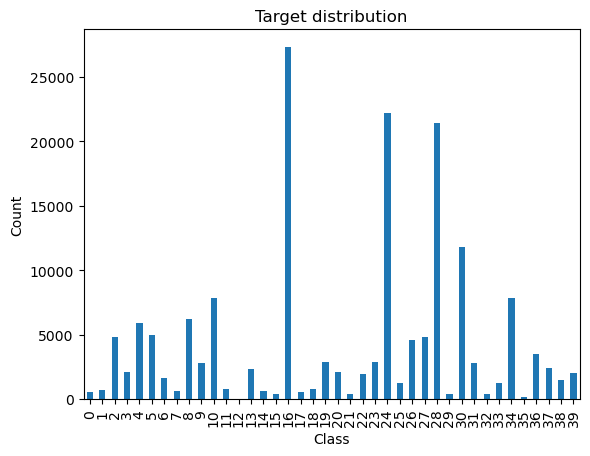

In [8]:
data['label'].value_counts().sort_index().plot(kind='bar')
plt.title("Target distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## Embedding Visualization

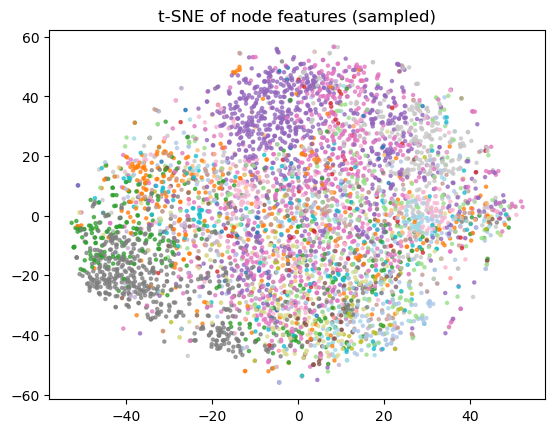

In [9]:
sample_size = 5000

X = data.drop('label', axis=1).values
y = data['label'].values

idx = np.random.choice(X.shape[0], sample_size, replace=False)
X_sample = X[idx]
y_sample = y[idx]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X_sample)

plt.scatter(X_2d[:,0], X_2d[:,1], c=y_sample, cmap="tab20", s=5, alpha=0.7)
plt.title("t-SNE of node features (sampled)")
plt.show()